In [257]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [258]:
class GridBoard:
    def __init__(self, cols, rows):
        self.rows = rows
        self.cols = cols
        self.rewards = pd.DataFrame(np.zeros((rows, cols)))
        self.walls = []
        #for w in self.walls:
        #   # check here to see if walls within the dataframe boundaries
        #    self.show_board[w[0]][w[1]] = "X"

        self.terminals = []  
        
        self.show_board = pd.DataFrame('.', index=range(self.rows), columns=range(self.cols))

        self.prevq = pd.DataFrame([[[0, 0, 0, 0] for j in range(self.cols)] for i in range(self.rows)], index=range(self.rows), columns=range(self.cols))

        # q_table of the ground truth when q-values converge
        self.qtruth = pd.DataFrame([[[0, 0, 0, 0] for j in range(self.cols)] for i in range(self.rows)], index=range(self.rows), columns=range(self.cols))

        # v table of where the ground truth of v values converage
        self.vtruth = pd.DataFrame(np.zeros((grid.rows, grid.cols)))
        self.prevv = pd.DataFrame(np.zeros((grid.rows, grid.cols)))



    
    def assignRewards(self, row, col, reward):
        self.rewards[row][col] = reward
    
    def assignTerminals(self, row, col):
        self.terminals.append([row, col])
    
    def reset_showboard(self):
        self.show_board = pd.DataFrame('.', index=range(self.rows), columns=range(self.cols))
        #for w in self.walls:
        #    self.show_board[w[0]][w[1]] = "X"
    
    def set_walls(self, walls):
        for w in walls:
            self.walls.append(w)
    
    def determineQtruth(self, iters, vBool):
        for i in range(0, len(iters)):
            #print("qtableBeforeRun")
            #print(player.qtable)
            print("prevqBeforeRun")
            print(self.prevq)

            run(False, iters[i], None, 1, True, 'ql') 

            #print("qtableAfterRun")
            #print(player.qtable)
            print("prevqAfterRun")
            print(self.prevq)
                
            if i > 0:        
                diffdf = pd.DataFrame([[[0, 0, 0, 0] for j in range(grid.cols)] for i in range(grid.rows)], index=range(grid.rows), columns=range(grid.cols))

                #print("qtable")
                #print(player.qtable)
                #print("prevq")
                #print(self.prevq)

                for c in range(0, len(player.qtable.columns)):
                    for r in range(0, len(player.qtable.index)):
                        for l in range(0, 4):   
                            diffdf[c][r][l] = round(player.qtable[c][r][l] - self.prevq[c][r][l],2)
                #print("diffdf")
                #print(diffdf)
                #print("qtruth")
                #print(self.qtruth)

                if self.qtruth.equals(diffdf):
                    print("CONVERGENCE!!!")              
                    self.qtruth = player.qtable[:]

                    if vBool == True:
                        print("in there")
                        for i in range(0, len(player.qtable.columns)):
                            for j in range(0, len(player.qtable.index)):                    
                                v = max(player.qtable[i][j])
                                self.vtruth[i][j] = v

                    return(iters)
                #done = False
                #for c in range(0, len(player.diffdf.columns)):
                #    for r in range(0, len(player.diffdf.index)):
                        
            for c in range(0, len(player.qtable.columns)):
                    for r in range(0, len(player.qtable.index)):
                        for l in range(0, 4):   
                            self.prevq[c][r][l] = player.qtable[c][r][l]
            #self.prevq = player.qtable.copy()
            #print('Prevq')
            #print(self.prevq)





In [259]:
class Player:
    def __init__(self, grid, start):
        self.start = start
        self.curr_state = self.start[:]
        grid.show_board[self.curr_state[0]][self.curr_state[1]] = "*"
        #self.state_count = pd.DataFrame(np.zeros((grid.rows, grid.cols)))
        #self.policy = pd.DataFrame(np.nan, index=range(0,grid.rows), columns=range(0,grid.cols))
        self.policy = pd.DataFrame(0, index=range(0,grid.rows), columns=range(0,grid.cols))
        self.v = pd.DataFrame(np.zeros((grid.rows, grid.cols)))
        self.vtable = pd.DataFrame(np.zeros((grid.rows, grid.cols)))

        # q_tables are a list within a dataframe cell with the directions [North, East, South, West], always start at 0
        self.qtable = pd.DataFrame([[[0, 0, 0, 0] for j in range(grid.cols)] for i in range(grid.rows)], index=range(grid.rows), columns=range(grid.cols))


    
    def move(self, direct):
        # determine if a move can occur
        # possible values for act: N, S, E, W
        # need next_state to find walls

        #next_state = self.detNextState(self.curr_state, direct)

        if direct == 'N':
            next_state = [self.curr_state[0], self.curr_state[1]-1]
            if self.curr_state[1] != 0 and next_state not in grid.walls: self.curr_state[1] -= 1 
            #if next_state not in grid.walls: self.curr_state[1] -= 1

        elif direct == 'E':
            next_state = [self.curr_state[0]+1, self.curr_state[1]]
            if next_state[0] < grid.cols and next_state not in grid.walls: self.curr_state[0] += 1 
            #if next_state not in grid.walls: self.curr_state[1] -= 1

        elif direct == 'S':
            next_state = [self.curr_state[0], self.curr_state[1]+1]
            if next_state[1] < grid.rows and next_state not in grid.walls: self.curr_state[1] += 1 
            #if next_state not in grid.walls: self.curr_state[1] += 1 

        elif direct == 'W':
            next_state = [self.curr_state[0]-1, self.curr_state[1]]
            if self.curr_state[0] != 0 and next_state not in grid.walls: self.curr_state[0] -= 1 
            #if next_state not in grid.walls: self.curr_state[0] -= 1 

        else:
            print("Invalid option")
        grid.reset_showboard()
        grid.show_board[self.curr_state[0]][self.curr_state[1]] = '*'
    
    def detNextState(self, curr_state, direct):

        if direct == 'N': next_state = [self.curr_state[0], self.curr_state[1]-1]
        elif direct == 'E': next_state = [self.curr_state[0]+1, self.curr_state[1]]
        elif direct == 'S': next_state = [self.curr_state[0], self.curr_state[1]+1]
        elif direct == 'W': next_state = [self.curr_state[0]-1, self.curr_state[1]]
        else: print("Invalid option")
        
        return next_state
    
    
    def findRandDirection(self):
        d = random.randint(1,4)
        if d == 1: return 'N'
        elif d == 2: return 'E'
        elif d == 3: return 'S'
        elif d == 4: return 'W'
        else:
            print("out of bounds")
        
    def detPolicyV(self):
        # determine policy & V table
        for i in range(0, len(player.policy.columns)):
            for j in range(0, len(player.policy.index)):
                dir = player.qtable[i][j].index(max(player.qtable[i][j]))         
                dirv = getDirChar(dir)
                player.policy[i][j] = dirv
                
                v = max(player.qtable[i][j])
                player.v[i][j] = v
    

 




            


In [260]:
class QLearn:
    def __init__(self, gamma, lr, deterministic):
        self.gamma = gamma
        self.deterministic = deterministic
        if not deterministic:
            self.lr = lr
        else:
            self.lr = 1
    
    def findQhat(self, rewards, qtable, cs, ns, d):
        qhat = 0
        if self.deterministic == True:
            if ns not in grid.walls:
                qhat = rewards[ns[0]][ns[1]] + self.gamma * max(qtable[ns[0]][ns[1]][0], qtable[ns[0]][ns[1]][1], qtable[ns[0]][ns[1]][2], qtable[ns[0]][ns[1]][3])
        else:
            if ns not in grid.walls:
                qhat = (1-self.lr) * qtable[cs[0]][cs[1]][d] + \
                    self.lr * (rewards[ns[0]][ns[1]] + self.gamma * \
                    max(qtable[ns[0]][ns[1]][0], qtable[ns[0]][ns[1]][1], qtable[ns[0]][ns[1]][2], qtable[ns[0]][ns[1]][3]))
                #print(qhat)

        return qhat
    
    def findSarsa(self, rewards, qtable, cs, ns, d):
        # difference with Sarsa is it follows a policy premade
        qhat = 0


        if ns not in grid.walls:
            nextDir = getDirInt(player.policy[ns[0]][ns[1]])
            #print("first policy next dir then next qtable of policy")
            #print(player.policy[ns[0]][ns[1]])
            #print(nextDir)
            #print(qtable[ns[0]][ns[1]][nextDir])
            qhat = (1-self.lr) * qtable[cs[0]][cs[1]][d] + self.lr * (rewards[ns[0]][ns[1]] + self.gamma * qtable[ns[0]][ns[1]][nextDir])
            
        return qhat

    def findV(self, rewards, qtable, cs, ns, d):
        # used for TD
        v = 0

        if ns not in grid.walls:
            nextDir = getDirInt(player.policy[ns[0]][ns[1]])
            #print("first policy next dir then next qtable of policy")
            #print(player.policy[ns[0]][ns[1]])
            #print(nextDir)
            #print(qtable[ns[0]][ns[1]][nextDir])
            v = player.vtable[cs[0]][cs[1]] + self.lr * (rewards[ns[0]][ns[1]] + self.gamma * (player.vtable[ns[0]][ns[1]] - player.vtable[cs[0]][cs[1]]))
            #v = (1-self.lr) * qtable[cs[0]][cs[1]][d] + self.lr * (rewards[ns[0]][ns[1]] + self.gamma * qtable[ns[0]][ns[1]][nextDir])
            
        return v

In [261]:
class Charts():
    def __init__(self, episodes):
        self.stepsGoal = pd.DataFrame(0, columns=['Steps'], index=range(1, episodes+1))
        self.stepsGoal.index.name = 'Episodes'
        #self.stepsGoal.insert(0, 'Episodes', self.stepsGoal.index)
        self.sse = pd.DataFrame(0, columns=['SSE'], index=range(1, episodes+1))

    
    def determineSSE(self):
        truthList = []
        currentQ = []
        sseVal = 0

        #print("inside qtruth")
        #print(grid.qtruth)

        # convert the DF of lists into a big list per DF
        for c in range(0, len(grid.qtruth.columns)):
            for r in range(0, len(grid.qtruth.index)):
                truthList.append(grid.qtruth[c][r])

        for c in range(0, len(player.qtable.columns)):
            for r in range(0, len(player.qtable.index)):
                currentQ.append(player.qtable[c][r])

        truthList = [j for i in truthList for j in i]
        currentQ = [j for i in currentQ for j in i]

        #print("truthList")
        #print(truthList)
        #print("currentQ")
        #print(currentQ)

        for t in range(0, len(truthList)):
            sseVal += (truthList[t] - currentQ[t])**2
        
        #print("sse")
        #print(sseVal)

        return sseVal

In [262]:
# function to create gridboard, set up walls & boundaries and assign rewards
# recieves: columns, rows, arewards array for rewards
def setupGrid(columns, rows, arewards, aterminals):
    grid = GridBoard(columns, rows)
    
    # create walls and boundaries, treat out of bounds as walls
    for c in range(0, grid.cols):
        grid.walls.append([c, -1])
        grid.walls.append([c, grid.rows])
    for r in range(0, grid.rows):
        grid.walls.append([-1, r])
        grid.walls.append([grid.cols, r])

    #print(grid.walls)

    for reward in arewards:
        grid.assignRewards(reward[0], reward[1], reward[2])
    
    for terminal in aterminals:
        grid.assignTerminals(terminal[0], terminal[1])
    


    #print(grid.terminals)

    return grid

In [263]:
def getDirInt(direct):
    d = 0
    if direct == 'N': d = 0
    elif direct == 'E': d = 1
    elif direct == 'S': d = 2
    elif direct == 'W': d = 3
    return d

def getDirChar(direct):
    d = ''
    if direct == 0: d = 'N'
    elif direct == 1: d = 'E'
    elif direct == 2: d = 'S'
    elif direct == 3: d = 'W'
    return d

In [264]:
# receives: pdef (if predefined path or not), iterations, path (none if not predefined)
def run(pdef, iters, path, eps, getQtruth, alg):

    #start = player.start
    
    if pdef == False:
        for i in range(0, iters):
            stepCount = 0
            while player.curr_state not in grid.terminals:
                x = player.curr_state[0]
                y = player.curr_state[1]

                p = np.random.random()
                if p < (1-eps):
                    if player.policy[x][y] != 0:
                        direct = player.policy[x][y]
                    else: 
                        direct = player.findRandDirection()
                else: # random
                    direct = player.findRandDirection()

                next_state = player.detNextState(player.curr_state, direct)

                d = getDirInt(direct)



                if alg == 'ql':
                    qhat = qlearn.findQhat(grid.rewards, player.qtable, player.curr_state, next_state, d)
                    qhat = round(qhat, 2)
                    player.qtable[x][y][d] = qhat
                elif alg == 'sarsa':
                    qhat = qlearn.findSarsa(grid.rewards, player.qtable, player.curr_state, next_state, d)
                    qhat = round(qhat, 2)
                    player.qtable[x][y][d] = qhat
                elif alg == 'td':
                    vhat = qlearn.findV(grid.rewards, player.qtable, player.curr_state, next_state, d)
                    vhat = round(vhat, 2)
                    player.vtable[x][y] = vhat   

                

                player.move(direct)

                stepCount += 1

                

                #print(player.curr_state)
                #print(grid.show_board)               

            if getQtruth == False:
                # determine the new policy and V table
                if alg == 'ql':
                    player.detPolicyV()

                # update the steps goal df
                charts.stepsGoal['Steps'][i+1] = stepCount

                # get SSE
                #print(i)
                #print(charts.sse)
                charts.sse['SSE'][i+1] = charts.determineSSE()
                

            # move player back to start position
            player.curr_state = player.start[:]
            #print(i)
            #print("after in Run: prevq")
            #print(grid.prevq)
            #print("after in Run: qtable")
            #print(player.qtable)   
        player.qtable = player.qtable.round(2)
        player.vtable = player.vtable.round(2)
        #print("each iteration vtable")
        #print(player.vtable)
        #print("each iteration qtable")
        #print(player.qtable)

    
    else:   
        for t in path:            
            for direct in t:
                x = player.curr_state[0]
                y = player.curr_state[1]
                #direct = player.findRandDirection()

                next_state = player.detNextState(player.curr_state, direct)

                d = getDirInt(direct)

                qhat = qlearn.findQhat(grid.rewards, player.qtable, player.curr_state, next_state, d)

                qhat = round(qhat, 2)

                player.qtable[x][y][d] = qhat

                player.move(direct)

                #print(player.curr_state)
                #print(grid.show_board)
            player.curr_state = player.start[:]

        player.qtable = player.qtable.round(2)

In [265]:
# Non-deterministic Homework example
aRewards = [[0, 2, 25], [1, 2, -100], [1, 0, -80], [2, 2, 80], [2, 0, 100]]
aTerminals = [[0, 2], [1, 2], [1, 0], [2, 2], [2, 0]]

grid = setupGrid(3, 3, aRewards, aTerminals)
player = Player(grid, [0, 0])
qlearn = QLearn(0.5, 0.5, False)

itersTruth = [50, 60, 70, 80]
grid.determineQtruth(itersTruth, False)



player = Player(grid, [0, 0])

iters = 10


print(player.curr_state)
print(grid.show_board)

path = [['S', 'E', 'S'], ['S', 'E', 'E', 'N'], ['S', 'E', 'E', 'S']]

run(True, iters, path, 0.1, False, 'ql')
#print(player.qtable)
print(grid.show_board)

#plt.figure()
#g1 = sns.lineplot(data=charts.stepsGoal)
#plt.figure()
#g2 = sns.lineplot(data=charts.sse)







prevqBeforeRun
              0             1             2
0  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]
1  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]
2  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]
prevqAfterRun
              0             1             2
0  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]
1  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]
2  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]
prevqBeforeRun
                       0                              1                      2
0   [0, -80.0, 12.49, 0]                   [0, 0, 0, 0]           [0, 0, 0, 0]
1  [6.24, 6.4, 24.99, 0]  [-60.0, 25.17, -93.75, 12.27]  [75.0, 0, 40.0, 2.67]
2           [0, 0, 0, 0]                   [0, 0, 0, 0]           [0, 0, 0, 0]
prevqAfterRun
                       0                              1                      2
0   [0, -80.0, 12.49, 0]                   [0, 0, 0, 0]           [0, 0, 0, 0]
1  [6.24, 6.4, 24.99, 0]  [-60.0, 25.17, -93.75, 12.27]  [75.0, 0, 40.0, 2.67]
2           [0, 0, 0, 0]             

prevqBeforeRun
              0             1             2
0  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]
1  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]
prevqAfterRun
              0             1             2
0  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]
1  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]
prevqBeforeRun
                   0                     1                   2
0  [0, 90.0, 0.0, 0]  [0, 100.0, 0.0, 0.0]        [0, 0, 0, 0]
1   [0.0, 0.0, 0, 0]      [0.0, 0.0, 0, 0]  [100.0, 0, 0, 0.0]
prevqAfterRun
                   0                     1                   2
0  [0, 90.0, 0.0, 0]  [0, 100.0, 0.0, 0.0]        [0, 0, 0, 0]
1   [0.0, 0.0, 0, 0]      [0.0, 0.0, 0, 0]  [100.0, 0, 0, 0.0]
                    0                       1                   2
0  [0, 90.0, 72.9, 0]  [0, 100.0, 81.0, 81.0]        [0, 0, 0, 0]
1   [81.0, 0.0, 0, 0]     [90.0, 0.0, 0, 0.0]  [100.0, 0, 0, 0.0]
   0  1  2
0  .  .  *
1  .  .  .


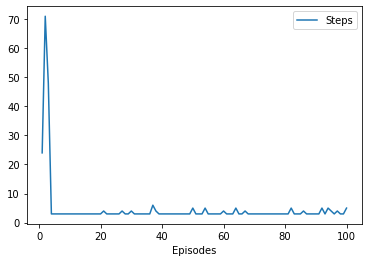

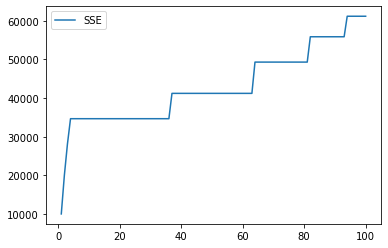

In [266]:
# Deterministic In class example
aRewards = [[2, 0, 100]]
aTerminals = [[2, 0]]

grid = setupGrid(3, 2, aRewards, aTerminals)
player = Player(grid, [0, 1])
qlearn = QLearn(0.9, None, True)

itersTruth = [2, 3]
grid.determineQtruth(itersTruth, False)

iters = 100
player = Player(grid, [0, 1])
charts = Charts(iters)

#print(player.curr_state)
#print(grid.show_board)

run(False, iters, None, 0.1, False, 'ql')
print(player.qtable)
print(grid.show_board)

player.detPolicyV()


plt.figure()
g1 = sns.lineplot(data=charts.stepsGoal)
plt.figure()
g2 = sns.lineplot(data=charts.sse)

prevqBeforeRun
              0             1             2             3             4
0  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]
1  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]
2  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]
3  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]
4  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]
prevqAfterRun
              0             1             2             3             4
0  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]
1  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]
2  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]
3  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]
4  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]
prevqBeforeRun
                          0                             1  \
0      [0, 47.81, 47.81, 0]    

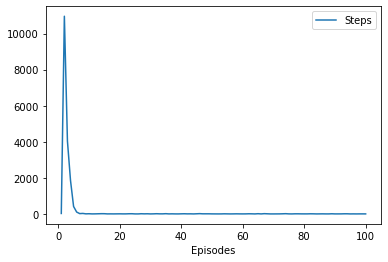

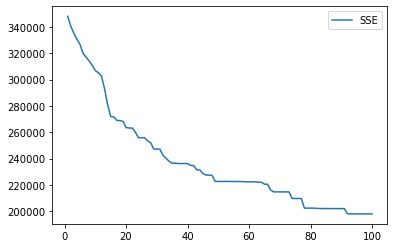

In [267]:
# finding the ground truth by determining at what level of iteration the diffences in the 
# qtables becoes small enough to conclude ground truth: using that as basis for 
# sum of squared errors calculation.

# Non-deterministic example
aRewards = [[4, 4, 100]]
aTerminals = [[4, 4]]

grid = setupGrid(5, 5, aRewards, aTerminals)
player = Player(grid, [0, 0])
qlearn = QLearn(0.9, 0.5, False)
#charts = Charts(runiters[i])

itersTruth = [50, 60, 70, 80]
grid.determineQtruth(itersTruth, False)

print("qtruth")
print(grid.qtruth)

runiters = [100]
for i in range(0, len(runiters)):

    player = Player(grid, [0, 0])
    charts = Charts(runiters[i])

    run(False, runiters[i], None, 0.3, False, 'ql')

    print(grid.show_board)

    player.detPolicyV()

    print(player.policy)

    plt.figure()
    g1 = sns.lineplot(data=charts.stepsGoal)
    plt.figure()
    g2 = sns.lineplot(data=charts.sse)

    

    


prevqBeforeRun
              0             1             2             3             4
0  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]
1  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]
2  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]
3  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]
4  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]
prevqAfterRun
              0             1             2             3             4
0  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]
1  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]
2  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]
3  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]
4  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]
prevqBeforeRun
                          0                             1  \
0      [0, 47.81, 47.81, 0]    

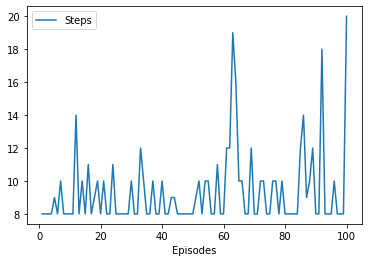

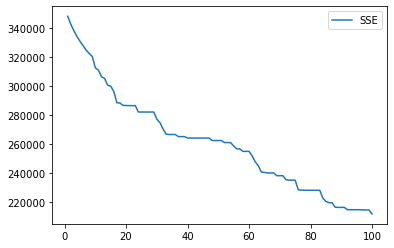

In [272]:
# SARSA
# predefined policy, not optimal
aRewards = [[4, 4, 100]]
aTerminals = [[4, 4]]

grid = setupGrid(5, 5, aRewards, aTerminals)
player = Player(grid, [0, 0])
qlearn = QLearn(0.9, 0.5, False)
#charts = Charts(runiters[i])

itersTruth = [50, 60, 70, 80]
grid.determineQtruth(itersTruth, False)

print("qtruth")
print(grid.qtruth)



runiters = [100]
for i in range(0, len(runiters)):

    p = [['S', 'E', 'E', 'E', 'S'], ['E', 'S', 'S', 'S', 'W'], ['N', 'E', 'E', 'S', 'S'], ['N', 'W', 'W', 'E', 'S'], ['N', 'W', 'W', 'E', 'N']]
    policy = pd.DataFrame(p)
    print(policy)

    player = Player(grid, [0, 0])
    player.policy = policy
    print(player.policy)
    charts = Charts(runiters[i])

    run(False, runiters[i], None, 0.1, False, 'sarsa')

    print(grid.show_board)

    #player.detPolicyV()

    print(player.policy)

    plt.figure()
    g1 = sns.lineplot(data=charts.stepsGoal)
    plt.figure()
    g2 = sns.lineplot(data=charts.sse)


    

    


In [269]:
# TD prediction
# Use the V table instead of the Q table, V table is updated on each iteration based on reward location

aRewards = [[4, 4, 100]]
aTerminals = [[4, 4]]

grid = setupGrid(5, 5, aRewards, aTerminals)
player = Player(grid, [0, 0])
qlearn = QLearn(0.9, 0.5, False)

# Create V table
player.v[4][4] = 100
print(player.v)


itersTruth = [100, 200, 500, 1000]

grid.determineQtruth(itersTruth, True)

print("vtruth")
print(grid.vtruth)
'''



runiters = [100]
for i in range(0, len(runiters)):

    p = [['S', 'E', 'E', 'E', 'S'], ['E', 'S', 'S', 'S', 'W'], ['N', 'E', 'E', 'S', 'S'], ['N', 'W', 'W', 'E', 'S'], ['N', 'W', 'W', 'E', 'N']]
    policy = pd.DataFrame(p)
    print(policy)

    player = Player(grid, [0, 0])
    player.policy = policy
    print(player.policy)
    charts = Charts(runiters[i])

    run(False, runiters[i], None, 0.1, False, 'td')

    print(grid.show_board)

    #player.detPolicyV()

    print(player.policy)

    plt.figure()
    g1 = sns.lineplot(data=charts.stepsGoal)
    plt.figure()
    g2 = sns.lineplot(data=charts.sse)
'''


     0    1    2    3      4
0  0.0  0.0  0.0  0.0    0.0
1  0.0  0.0  0.0  0.0    0.0
2  0.0  0.0  0.0  0.0    0.0
3  0.0  0.0  0.0  0.0    0.0
4  0.0  0.0  0.0  0.0  100.0
prevqBeforeRun
              0             1             2             3             4
0  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]
1  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]
2  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]
3  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]
4  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]
prevqAfterRun
              0             1             2             3             4
0  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]
1  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]
2  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]
3  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]  [0, 0, 0, 0]
4  [0

"\n\n\n\nruniters = [100]\nfor i in range(0, len(runiters)):\n\n    p = [['S', 'E', 'E', 'E', 'S'], ['E', 'S', 'S', 'S', 'W'], ['N', 'E', 'E', 'S', 'S'], ['N', 'W', 'W', 'E', 'S'], ['N', 'W', 'W', 'E', 'N']]\n    policy = pd.DataFrame(p)\n    print(policy)\n\n    player = Player(grid, [0, 0])\n    player.policy = policy\n    print(player.policy)\n    charts = Charts(runiters[i])\n\n    run(False, runiters[i], None, 0.1, False, 'td')\n\n    print(grid.show_board)\n\n    #player.detPolicyV()\n\n    print(player.policy)\n\n    plt.figure()\n    g1 = sns.lineplot(data=charts.stepsGoal)\n    plt.figure()\n    g2 = sns.lineplot(data=charts.sse)\n"

In [270]:
iters = [100, 500, 700, 1000, 5000]
for i in range(0, len(iters)):
    # Deterministic Qlearning
    aRewards = [[2, 0, 100]]

    #iters = 50
    grid = setupGrid(3, 2, aRewards)
    player = Player(grid, [0, 1])
    qlearn = QLearn(0.9, None, True)
    charts = Charts(iters[i])

    #print(player.curr_state)
    #print(grid.show_board)

    run(False, iters[i], None, 1)
    print(player.qtable)
    #print(grid.show_board)

    player.detPolicyV()
    #print(player.policy)
    #print(player.v)


    if i > 0:
        charts.determineSSE()


    '''
    if i > 0:
        print("test")
        print(i)
        diffdf = pd.DataFrame([[[0, 0, 0, 0] for j in range(grid.cols)] for i in range(grid.rows)], index=range(grid.rows), columns=range(grid.cols))
        for c in range(0, len(player.qtable.columns)):
            for r in range(0, len(player.qtable.index)):
                for l in range(0, 4):   
                    diffdf[c][r][l] = round(player.qtable[c][r][l] - prevq[c][r][l],2)
        print(diffdf)
        prevq = player.qtable
    '''
    


    #print(charts.stepsGoal)

    #sns.lineplot(data=charts.stepsGoal)

TypeError: setupGrid() missing 1 required positional argument: 'aterminals'

In [160]:
aRewards = [[2, 2, 100]]

iters = 100 
grid = setupGrid(3, 2, aRewards)
player = Player(grid, [0, 0])
# parameters: gamma, learning rate, deterministic?
qlearn = QLearn(0.9, 0.5, False)
charts = Charts(iters[i])

#print(player.curr_state)
#print(grid.show_board)

# parameters: predefined?, iterations, path (None if none)
run(False, iters, None)
print(player.qtable)
print(grid.show_board)

player.detPolicyV()
print(player.policy)
print(player.v)


print(charts.stepsGoal)

sns.lineplot(data=charts.stepsGoal)

TypeError: 'int' object is not subscriptable

In [326]:
print(player.policy[player.curr_state[0]][player.curr_state[1]])

N


In [327]:
import random
t = []
for i in range(1, 11):
    t.append([i, random.randint(1,11)])
print(t)

import random
m = []
for i in range(1, 11):
    m.append([i, random.randint(1,11)])
print(m)

combo = m + t
combo = [[2, 4], [3, 5], [3, 1], [6, 9], [10, 8]]
test = pd.DataFrame(combo, columns=['Steps1', 'Steps2'])
print(test)

[[1, 9], [2, 11], [3, 3], [4, 6], [5, 2], [6, 9], [7, 10], [8, 10], [9, 1], [10, 4]]
[[1, 5], [2, 11], [3, 9], [4, 10], [5, 7], [6, 11], [7, 7], [8, 6], [9, 9], [10, 6]]
   Steps1  Steps2
0       2       4
1       3       5
2       3       1
3       6       9
4      10       8


In [328]:
x = random.sample(range(10, 30), 10)

In [329]:
print(x)


[13, 23, 28, 12, 10, 22, 20, 15, 18, 11]


<AxesSubplot:>

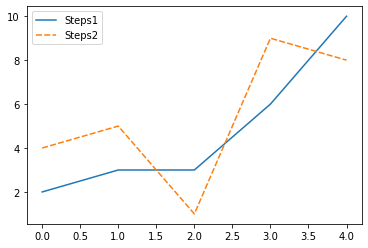

In [330]:
#newtest = test['Steps']
#newtest.index.name = 'Episodes'
#print(newtest)
sns.lineplot(data=test)